## Twitter Sentiment Analysis for US Airlines

#### It is a (multi- class) classifictaion problem where we attempt to classify a particular tweet into 3 labels: 'positive', 'negative' or 'neutral'. Attempted techniques: Deep Learning (LSTM and GRU), Random Forest, XGBoost and Multinomila Logistic Regression. Metrics used to observe the performance: Accuracy, Precision-Recall

In [1]:
#relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding

from sklearn.model_selection import train_test_split


In [ ]:
# input tweets data
tweets=pd.read_csv("Tweets.csv")
tweets.head()

In [ ]:
# keep relevant variables for classification of sentiments- sentiment & tweet text

tweets_data=tweets[['airline_sentiment','text']]
tweets_data.shape
# data has 14,640 observations

In [56]:
#check for missingness
tweets_data.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

In [57]:
# convert string sentiment categories to numeric data
tweets_data['sentiment_type']=tweets_data['airline_sentiment'].replace({'positive':2,'neutral':1,'negative':0})
tweets_data.head()

C:\Users\aditi\Anaconda3_3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,airline_sentiment,text,sentiment_type
0,neutral,@VirginAmerica What @dhepburn said.,1
1,positive,@VirginAmerica plus you've added commercials t...,2
2,neutral,@VirginAmerica I didn't today... Must mean I n...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [58]:
X=tweets_data['text']
y=tweets_data['sentiment_type']

### Preprocessing data

In [59]:
#tokenize the text 
token=Tokenizer()
token.fit_on_texts(X)

In [60]:
# Find number of unique words in our tweets
vocab_size = len(token.word_index)+1
vocab_size

15769

In [61]:
# integer encode tweets' text
sequences = token.texts_to_sequences(X)
#sequences

In [62]:
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

tweet_maxlength = max_tweet()
tweet_maxlength

30

In [63]:
#substituting lesser length's sequences with 0 to make all sequences of equal lengths
padded_X = pad_sequences(sequences, padding='post', maxlen=tweet_maxlength)

In [64]:
#One-hot Encoding for airline sentiment
labels = to_categorical(np.asarray(y))
labels

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [65]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.3, random_state = 1011)

### Word Embedding using Pre- trained GloVe Embedding

In [66]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# used 100 dimensional version (embedding dimension)- load into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [67]:
# create a "weight matrix" for words using the unique words in our training data and their GloVe vector representation

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [68]:
# Create embedding layer using GloVe embedding weights
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_maxlength, trainable=False) # since we do want to update the word weights

### Modeling

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization

### 1. Long Short- term Memory (LSTM)

#### Hyper-parameters: no. of layers, output dimension per layer, regularization: drpout and recurrent dropout rates per layer

##### Model 1- (dim= 256 (first layer), dropout=0.2, recurrent dropout=0.5)


In [80]:
# define model
mod1 = Sequential()
mod1.add(embedding_layer)
mod1.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
mod1.add(Dense(3, activation='softmax')) # dense vector of 3 nodes for 3 labels
# compile the model
mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [81]:
# summarize the model
mod1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1576900   
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 1,943,239
Trainable params: 366,339
Non-trainable params: 1,576,900
_________________________________________________________________


In [82]:
# fit the model keeping 20% data for validation. Trained for 100 epochs and batch sze of 256
model_1 = mod1.fit(X_train,y_train, validation_split=0.2, epochs=100, verbose=0, batch_size=256)

In [83]:
# Insample & OOS model performance
loss, accuracy = mod1.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy: %f' % (accuracy*100))
loss, accuracy = mod1.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy: %f' % (accuracy*100))

Training Accuracy: 89.910227
Testing Accuracy: 80.236793


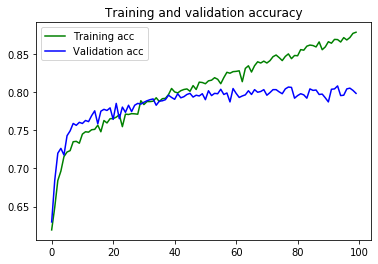

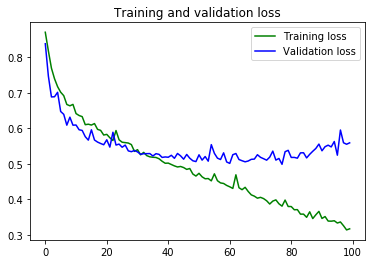

In [84]:
# Plot train/test loss and accuracy
acc = model_1.history['acc']
val_acc = model_1.history['val_acc']
loss = model_1.history['loss']
val_loss = model_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [85]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [86]:
# Get predicted values
y_pred = mod1.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

In [87]:
# Convert y_test to 1d numpy array
y_test_array = np.zeros(X_test.shape[0])

# Find class with 1
for i in range(0, y_test.shape[0]):
    label_predict = np.argmax(y_test[i])
    y_test_array[i] = label_predict

y_test_array = y_test_array.astype(int)

In [88]:
class_names = np.array(['Negative', 'Neutral', 'Positive'])

Confusion matrix, without normalization
[[2470  182  108]
 [ 246  563  115]
 [ 122   95  491]]
Normalized confusion matrix
[[0.89 0.07 0.04]
 [0.27 0.61 0.12]
 [0.17 0.13 0.69]]


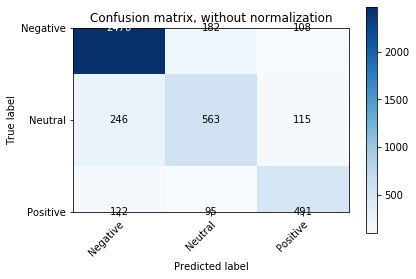

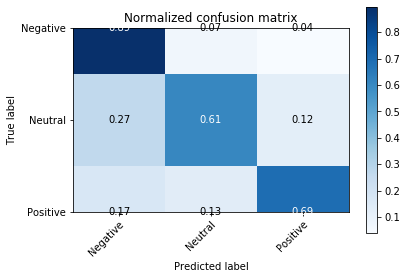

In [91]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 2- reduced dimensionality

##### Model 2- (dim= 128 (first layer), dropout=0.2, recurrent dropout=0.5)

In [92]:
# define model
mod2 = Sequential()
mod2.add(embedding_layer)
mod2.add(LSTM(128, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
mod2.add(Dense(3, activation='softmax')) 
# compile the model
mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# summarize the model
mod2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1576900   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 1,694,535
Trainable params: 117,635
Non-trainable params: 1,576,900
_________________________________________________________________


In [93]:
# fit the model keeping 20% data for validation. Trained for 100 epochs and batch sze of 256
model_2 = mod2.fit(X_train,y_train, validation_split=0.2, epochs=100, verbose=0, batch_size=256)

Training Accuracy: 87.002343
Testing Accuracy: 79.781419


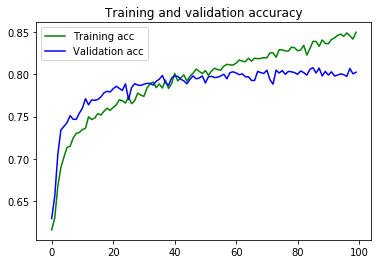

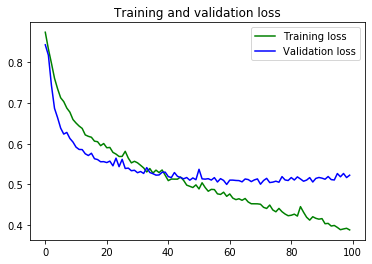

In [94]:
# Insample & OOS model performance
loss, accuracy = mod2.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy: %f' % (accuracy*100))
loss, accuracy = mod2.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy: %f' % (accuracy*100))

# Plot train/test loss and accuracy
acc = model_2.history['acc']
val_acc = model_2.history['val_acc']
loss = model_2.history['loss']
val_loss = model_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [98]:
# Get predicted values
y_pred = mod2.predict(X_test)  
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[2519  155   86]
 [ 313  514   97]
 [ 141   96  471]]
Normalized confusion matrix
[[0.91 0.06 0.03]
 [0.34 0.56 0.1 ]
 [0.2  0.14 0.67]]


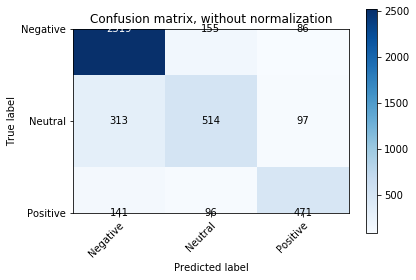

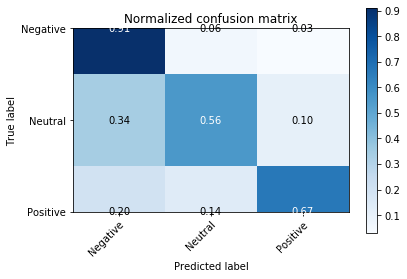

In [99]:

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 3 - Reduced dimensionality, added layer (Stacking)

##### Model 3- (dim= 64 (first layer), 128(second layer), dropout=0.2, recurrent dropout=0.5)

In [101]:
# define model
mod3 = Sequential()
mod3.add(embedding_layer)
mod3.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
               return_sequences = True))
mod3.add(LSTM(128, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
mod3.add(Dense(3, activation='softmax')) 

# compile the model
mod3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# summarize the model
mod3.summary()

# fit the model keeping 20% data for validation. Trained for 100 epochs and batch sze of 256
model_3 = mod3.fit(X_train,y_train, validation_split=0.2, epochs=100, verbose=0, batch_size=256)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1576900   
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 64)            42240     
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 1,718,343
Trainable params: 141,443
Non-trainable params: 1,576,900
_________________________________________________________________


ResourceExhaustedError:  OOM when allocating tensor with shape[30,256,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node sequential_6/lstm_8/TensorArrayV2Stack/TensorListStack (defined at <ipython-input-101-8da60fe9873e>:20) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_107772]

Function call stack:
distributed_function


In [ ]:
# Insample & OOS model performance
loss, accuracy = mod2.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy: %f' % (accuracy*100))
loss, accuracy = mod2.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy: %f' % (accuracy*100))

# Plot train/test loss and accuracy
acc = model_3.history['acc']
val_acc = model_3.history['val_acc']
loss = model_3.history['loss']
val_loss = model_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Get predicted values
y_pred = mod3.predict(X_test)  
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()